In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.append('../../utils')
import lec9_graphs as afx

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 6)

## AdaBoost

Se entrega un peso en cada iteración a las observaciones
A medida que va iterando le entrega un peso mayor a las observaciones que son dificiles de clasificar, logrando que los clasificadores se centren en esas muestras.

In [4]:
from sklearn.ensemble import AdaBoostClassifier

## Deteccion de spam

In [5]:
df = pd.read_csv('../../data/un5_spamdata_esl_colnames.csv').drop(columns='Unnamed: 0')
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


### Analisis Exploratorio

0    0.61
1    0.39
Name: spam, dtype: float64


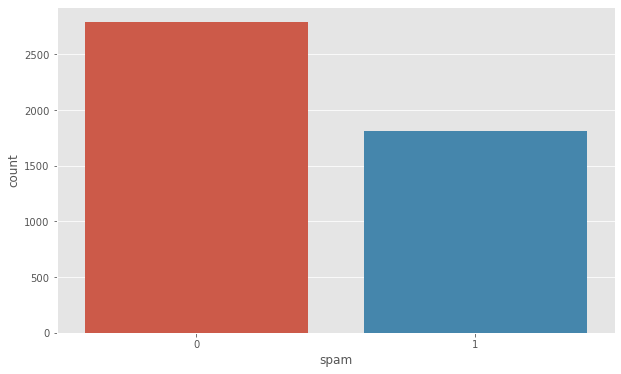

In [6]:
print(df['spam'].value_counts('%').round(2))
sns.countplot(df['spam']);

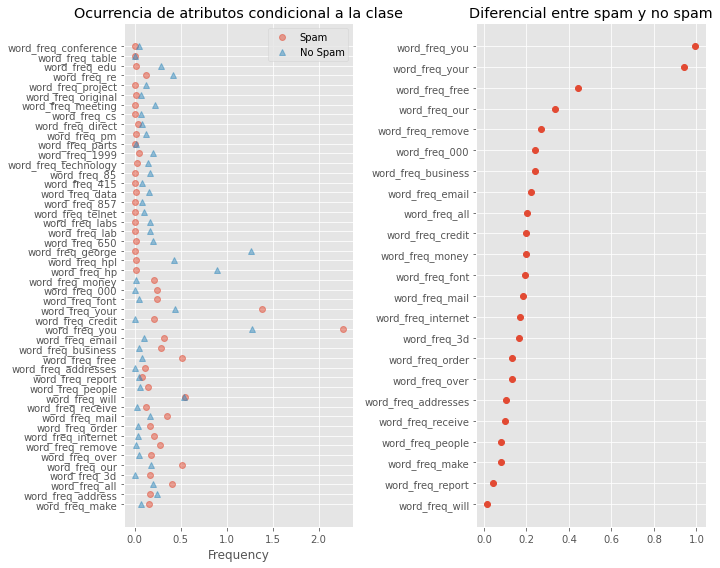

In [7]:
plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
exclude_df = df.filter(regex='word_freq_*')
exclude_df['spam'] = df['spam']

store_means_no_spam = exclude_df.query('spam == 0').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)
store_means_spam = exclude_df.query('spam == 1').drop(columns='spam').apply(lambda x: np.mean(x), axis=0)
plt.plot(store_means_spam, store_means_spam.index, 'o', alpha=.5, label="Spam")
plt.plot(store_means_no_spam, store_means_no_spam.index, '^', alpha=.5, label="No Spam")
plt.xlabel('Frequency')
plt.title('Ocurrencia de atributos condicional a la clase')
plt.legend();


plt.subplot(1, 2,2)
store_diff = store_means_spam - store_means_no_spam
store_diff = store_diff[store_diff > 0].sort_values()
plt.plot(store_diff, store_diff.index, 'o')
plt.title('Diferencial entre spam y no spam')
plt.tight_layout()

## Clasificacion

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:,'word_freq_make':'capital_run_length_total'],
                                                    df['spam'],
                                                    test_size=.33, random_state=11238)


In [8]:
decision_stump = DecisionTreeClassifier(max_depth=10, random_state=11238).fit(X_train, y_train)
adaboost_classifier = AdaBoostClassifier(base_estimator=decision_stump, random_state=11238).fit(X_train, y_train)

In [9]:
tree_y_hat = decision_stump.fit(X_train, y_train).predict(X_test)
adaboost_y_hat = adaboost_classifier.fit(X_train, y_train).predict(X_test)
adaboost_pr = adaboost_classifier.fit(X_train, y_train).predict_proba(X_test)

# generamos el reporte
print("Decision Stump:")
print(classification_report(y_test, tree_y_hat, digits=3))
print("\n\nAdaptative Boosting Classifier:")
print("Cantidad de Estimadores:", adaboost_classifier.n_estimators, "\n")
print(classification_report(y_test, adaboost_y_hat, digits=3))

Decision Stump:
              precision    recall  f1-score   support

           0      0.930     0.932     0.931       912
           1      0.898     0.895     0.896       607

    accuracy                          0.917      1519
   macro avg      0.914     0.913     0.914      1519
weighted avg      0.917     0.917     0.917      1519



Adaptative Boosting Classifier:
Cantidad de Estimadores: 50 

              precision    recall  f1-score   support

           0      0.948     0.956     0.952       912
           1      0.933     0.921     0.927       607

    accuracy                          0.942      1519
   macro avg      0.941     0.939     0.939      1519
weighted avg      0.942     0.942     0.942      1519



## Comportamiento

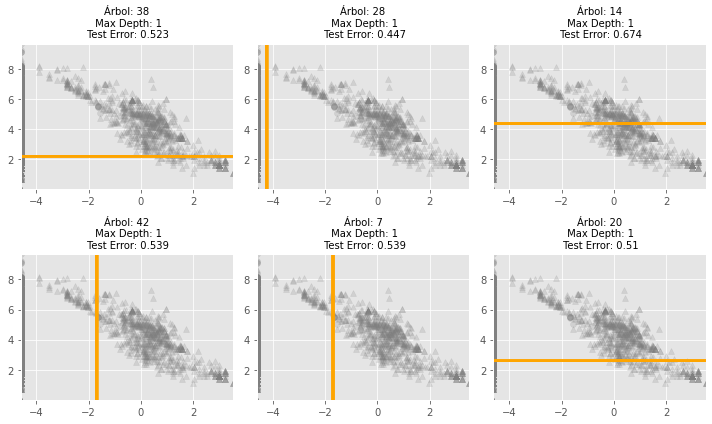

In [11]:
np.random.seed(42)
afx.adaboost_weak_learner_behavior()

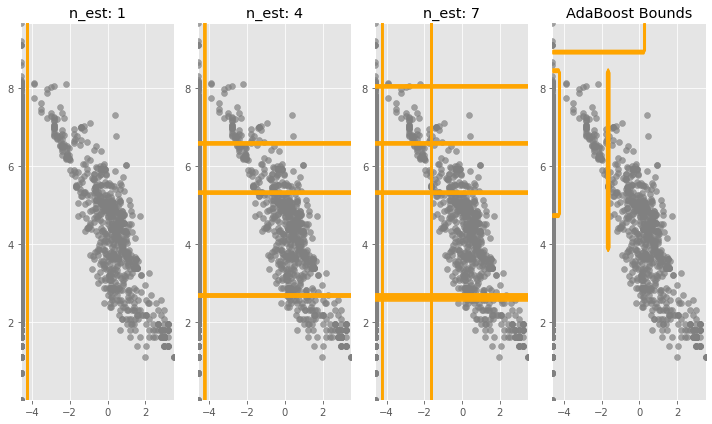

In [12]:
afx.adaboost_adaptive_behavior()

In [13]:
store_pr = []
for i in adaboost_classifier.staged_predict_proba(X_test):
    store_pr.append(i)

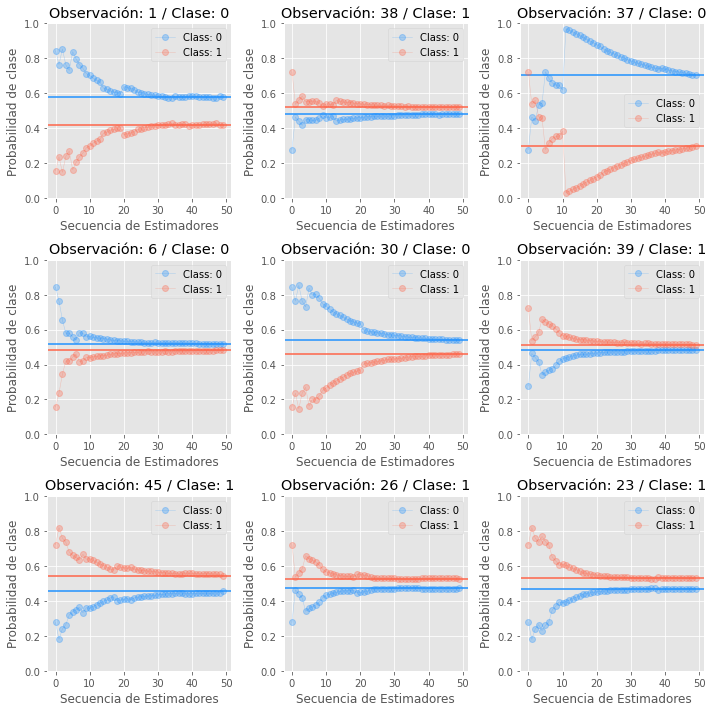

In [14]:
plt.figure(figsize=(10, 10))
np.random.seed(11238)
for index, value in enumerate(np.random.randint(1, 50, size=9)):
    plt.subplot(3, 3, index + 1)
    mlc = afx.adaboost_classification_behavior(store_pr, adaboost_pr, value)
    plt.title(f'Observación: {value} / Clase: {mlc}')
    plt.ylim((0, 1))
    plt.ylabel('Probabilidad de clase')
    plt.xlabel('Secuencia de Estimadores')
    plt.tight_layout()

In [55]:
store_acc = np.empty(adaboost_classifier.n_estimators)

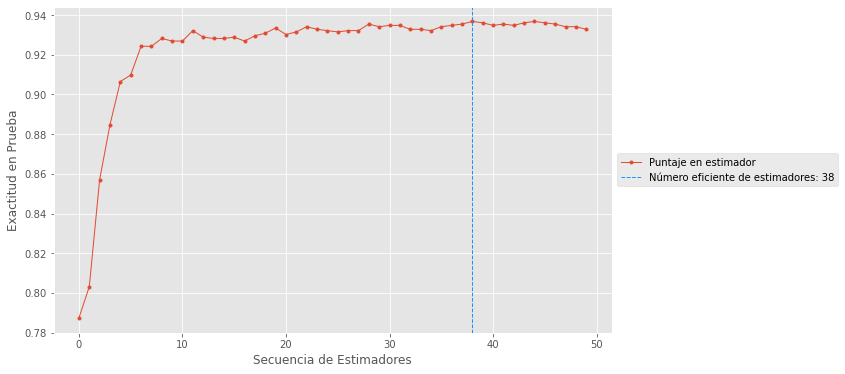

In [15]:
store_acc = np.empty(adaboost_classifier.n_estimators)
for index, value in enumerate(adaboost_classifier.staged_score(X_test, y_test)):
    store_acc[index] = value

signal_optim = np.where(store_acc == np.max(store_acc))[0][0]
plt.plot(store_acc, '.-', lw=1, label='Puntaje en estimador')
plt.axvline(signal_optim, color='dodgerblue', lw=1, linestyle='--', 
            label=f'Número eficiente de estimadores: {signal_optim}')
plt.xlabel('Secuencia de Estimadores')
plt.ylabel('Exactitud en Prueba')
plt.legend(loc='center left', bbox_to_anchor=(1, .5));

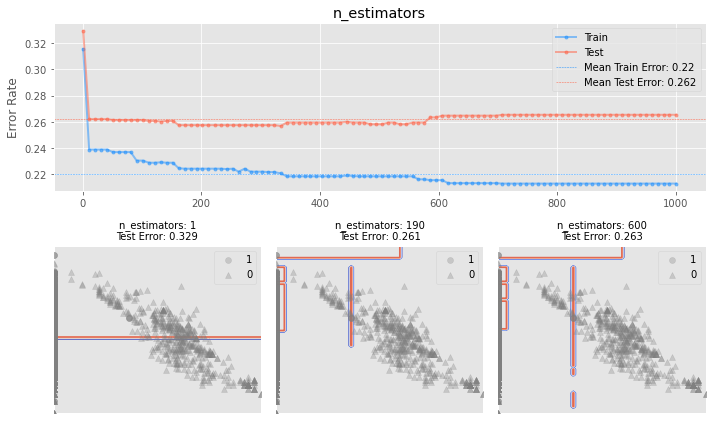

In [56]:
## NO CORRER DE NUEVO
afx.n_estimators_hyperparams()

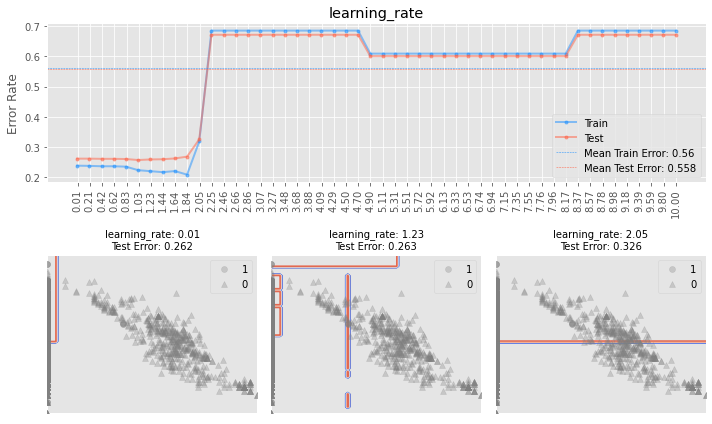

In [57]:
afx.learning_rate_hyperparams()

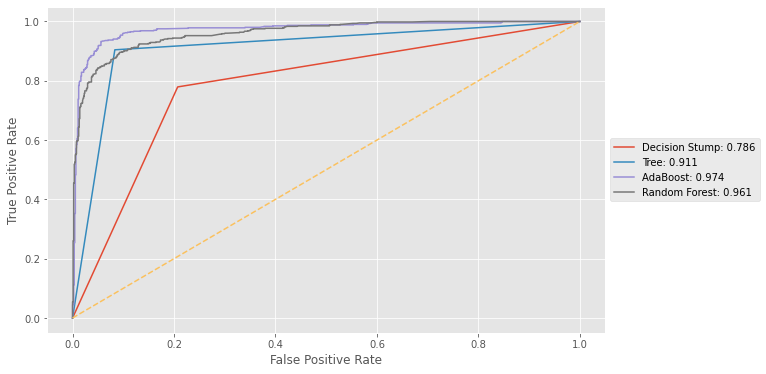

In [61]:
# imitamos el comportamiento de árboles débiles con un decision stump
tree_decision_stump = DecisionTreeClassifier(max_depth=1).fit(X_train, y_train)
tree_model = DecisionTreeClassifier().fit(X_train, y_train)
rf_model = RandomForestClassifier(max_depth=1).fit(X_train, y_train)
adaboost_model = AdaBoostClassifier(base_estimator = tree_decision_stump, random_state=11238).fit(X_train, y_train)


afx.plot_roc(model=tree_decision_stump, y_true= y_test, X_test=X_test, model_label = "Decision Stump")
afx.plot_roc(model=tree_model, y_true= y_test, X_test=X_test, model_label = "Tree")
afx.plot_roc(model=adaboost_model, y_true= y_test, X_test=X_test,model_label="AdaBoost")
afx.plot_roc(model=rf_model,y_true= y_test, X_test=X_test, model_label="Random Forest")
plt.plot([0, 1], ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, .5));

## Gradient Boosting

Se utiliza una función de pérdida para ir iterando.
Se actualiza utilizando los residuos

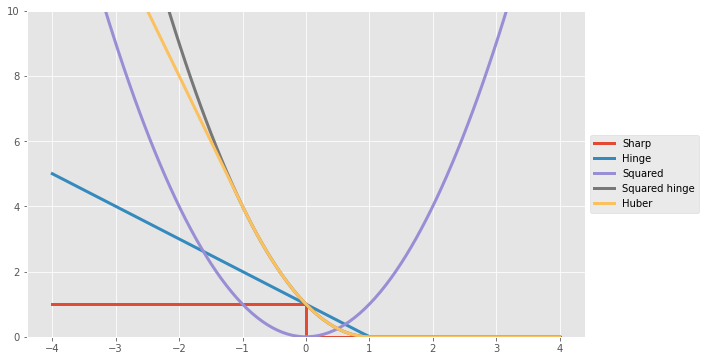

In [62]:
afx.loss_functions()

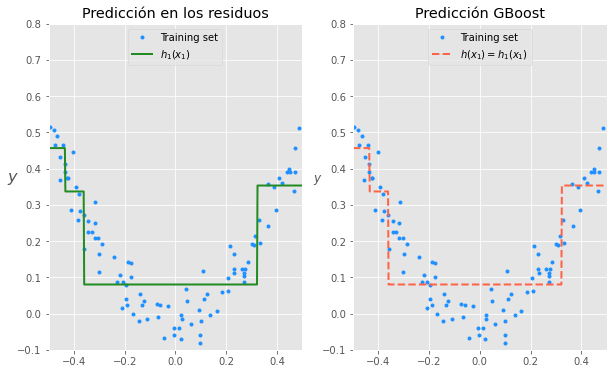

In [63]:
afx.gboost_stage_one()

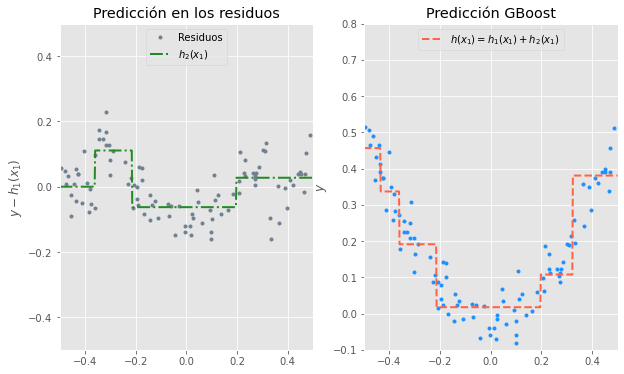

In [64]:
afx.gboost_stage_two()

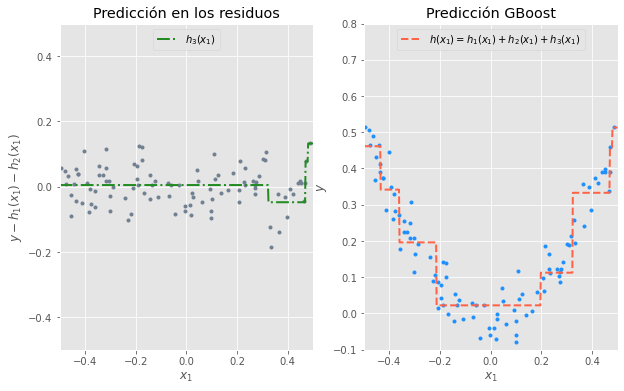

In [65]:
afx.gboost_stage_three()

In [66]:
from sklearn.ensemble import GradientBoostingClassifier
gradient_boost_model = GradientBoostingClassifier().fit(X_train, y_train)
y_hat = gradient_boost_model.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       912
           1       0.94      0.93      0.94       607

    accuracy                           0.95      1519
   macro avg       0.95      0.95      0.95      1519
weighted avg       0.95      0.95      0.95      1519



In [68]:
gradient_boost_model.estimators_[0][0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                             random_state=RandomState(MT19937) at 0x207920AA340)],
      dtype=object)

In [69]:
print(type(gradient_boost_model.loss_))

<class 'sklearn.ensemble._gb_losses.BinomialDeviance'>


Text(0, 0.5, 'Test BinomialDeviance')

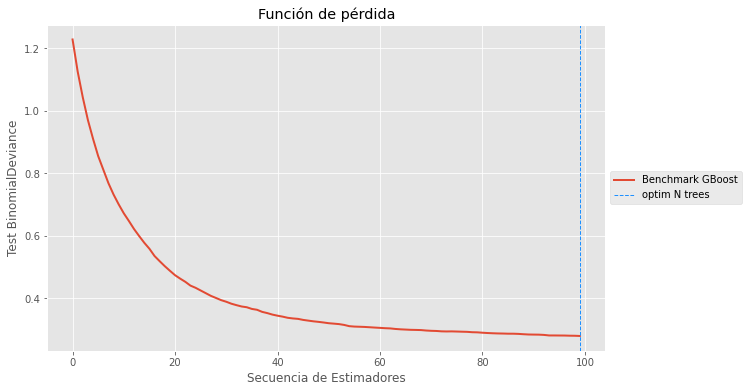

In [70]:
gb_loss_1, optim = afx.profile_loss_function(gradient_boost_model, X_test, y_test)
plt.plot(gb_loss_1, label = 'Benchmark GBoost', lw=2)
plt.axvline(optim, label='optim N trees', lw=1, linestyle='--', color='dodgerblue')
plt.legend(loc='center left', bbox_to_anchor=(1, .5))
plt.title('Función de pérdida')
plt.xlabel('Secuencia de Estimadores')
plt.ylabel('Test BinomialDeviance')

In [71]:
print("Exactitud Gboost en Testing: ",
gradient_boost_model.score(X_test, y_test).round(3))
print("Exactitud Gboost en Training: ",
gradient_boost_model.score(X_train, y_train).round(3))

Exactitud Gboost en Testing:  0.949
Exactitud Gboost en Training:  0.964


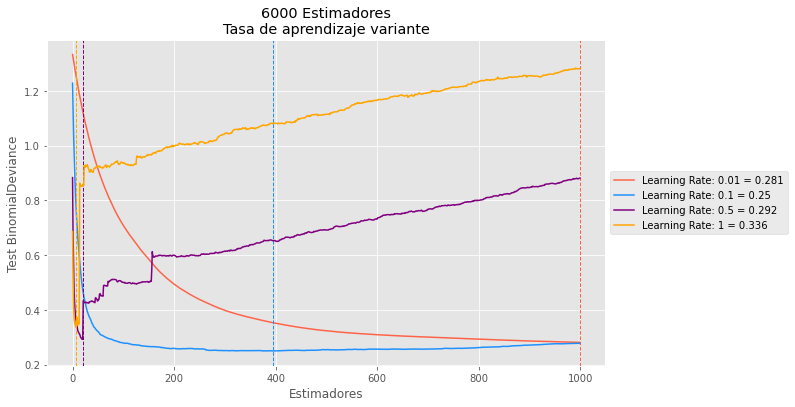

In [72]:
afx.gboost_learning_hyperparams(X_train, X_test, y_train, y_test)

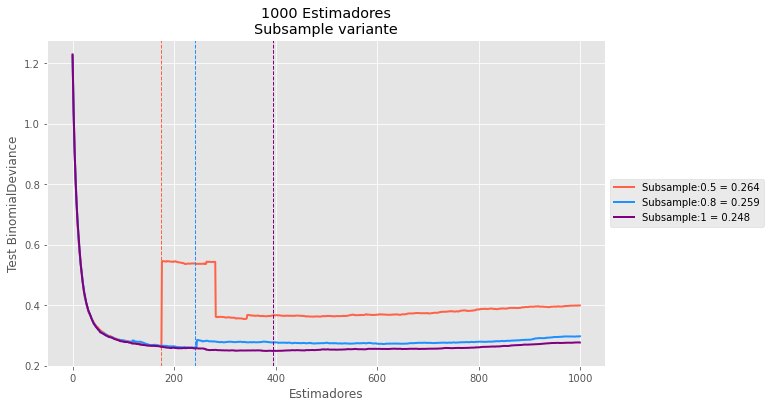

In [73]:
afx.gboost_sampling_hyperparams(X_train, X_test, y_train, y_test)

In [91]:
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
              'subsample': np.linspace(0.1, 1.0, 5, endpoint=True,
                                       dtype=float),
             }

In [92]:
from sklearn.model_selection import GridSearchCV
gb_grid = GridSearchCV(GradientBoostingClassifier(), param_grid = param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

In [93]:
y_hat = gb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       912
           1       0.94      0.95      0.95       607

    accuracy                           0.96      1519
   macro avg       0.95      0.96      0.95      1519
weighted avg       0.96      0.96      0.96      1519



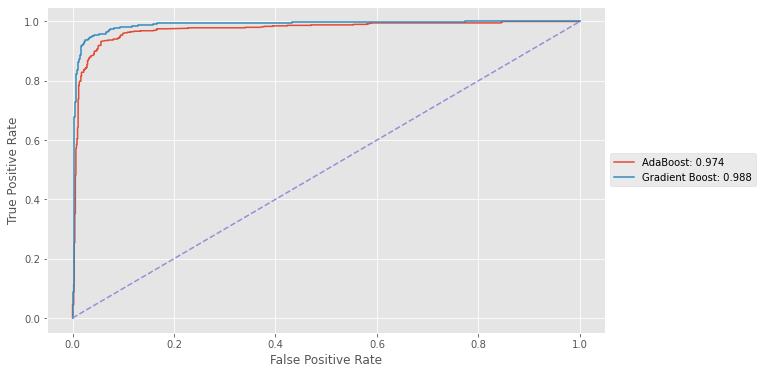

In [94]:
afx.plot_roc(model=adaboost_model, y_true= y_test, X_test=X_test,model_label="AdaBoost")
afx.plot_roc(model=gb_grid.best_estimator_, y_true= y_test, X_test=X_test,model_label="Gradient Boost")
plt.plot([0, 1], ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

### XGBOOST

In [95]:
from xgboost import XGBClassifier

In [96]:
param_grid = {'n_estimators': [100, 500, 1000],
              'learning_rate': [0.01, 0.1, 0.5, 1, 5, 10],
              'subsample': np.linspace(0.1, 1.0, 5, endpoint=True,
                                       dtype=float),
             }

In [97]:
X_train.columns = [ ci.replace('[', '').replace(']', '').replace('<','') for ci in X_train.columns]
X_test.columns = [ ci.replace('[', '').replace(']', '').replace('<','') for ci in X_test.columns]

In [98]:
xgb_grid = GridSearchCV(XGBClassifier(), param_grid = param_grid, cv=5, n_jobs=-1).fit(X_train, y_train)

[21:49:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [99]:
y_hat = xgb_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       912
           1       0.94      0.95      0.94       607

    accuracy                           0.96      1519
   macro avg       0.95      0.95      0.95      1519
weighted avg       0.96      0.96      0.96      1519



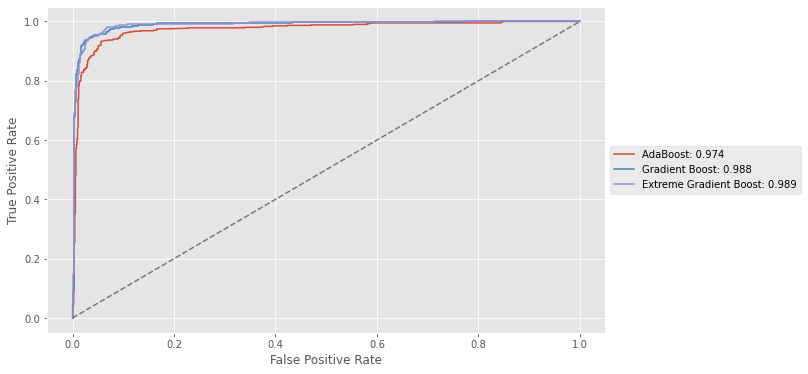

In [100]:
afx.plot_roc(model=adaboost_model, y_true= y_test, X_test=X_test,model_label="AdaBoost")
afx.plot_roc(model=gb_grid.best_estimator_, y_true= y_test, X_test=X_test,model_label="Gradient Boost")
afx.plot_roc(model=xgb_grid.best_estimator_, y_true= y_test, X_test=X_test,model_label="Extreme Gradient Boost")
plt.plot([0, 1], ls="--")
plt.legend(loc='center left', bbox_to_anchor=(1, .5))

In [12]:
texto = ['el dia de hoy estaba muy soleado y fui al parque a jugar a la pelota','asgdasdgsadg','sadgasgdsadg','sadgasgd']
y = ['felicidad', 'soledad','felicidad','emocion', 'neutral']
df = pd.DataFrame({'texto':texto, 'y':y})
df['y2'] = ['positivo', 'negativo', 'positivo','positivo', 'positivo']

In [14]:
df[['texto', 'y2']]

,texto,y2
0,asdfasdgfasdgas,negativo
1,asgdasdgsadg,negativo
2,sadgasgdsadg,positivo
3,sadgasgd,positivo
